# Step scaling (purple plot): r1=1.414 r2=2.236 r3=2.82


In [1]:
import qiskit
#qiskit.__version__
from scipy.sparse.linalg import eigsh
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt
import sys
import glob
sys.path.append("../../") # go to parent dir
from itertools import permutations,product
from tqdm.notebook import tqdm
import datetime
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from Hamiltonian_QED_sym import HamiltonianQED_sym
from Hamiltonian_QED_oprt import HamiltonianQED_oprt
from HC_Lattice import HCLattice
from Ansaetze import Ansatz
import primme
from Observables import *
from Fidelity_func import *

#Qiskit import
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_distribution
from qiskit.circuit import Parameter
from qiskit.primitives import Sampler, Estimator
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit.quantum_info import SparsePauliOp, Pauli, Operator
from sys import stdout
from qiskit_algorithms.optimizers import NFT,SLSQP,COBYLA,ADAM,SPSA,QNSPSA,CG,GradientDescent,L_BFGS_B,P_BFGS
import qiskit.quantum_info as qinf
from qiskit_algorithms.minimum_eigensolvers import VQE


/var/folders/08/fx8gnyrx18jggry6_s4cbtz40000gn/T/ipykernel_87955/14888135.py:19: DeprecationWarning: Please use `aslinearoperator` from the `scipy.sparse.linalg` namespace, the `scipy.sparse.linalg.interface` namespace is deprecated.
  import primme


##### Hamiltonian

In [2]:
#class input parameters:
n_sites = [3,3]#how many sites for every dimension
g=0.1
fact_e_op = 1
fact_b_op = 1
m=0
omega=0
l=1
L=4
rotors = False
lambd = 1000
encoding = 'gray' ##'ed'#
magnetic_basis=False
pbc=False
puregauge = True
static_charges_values =None#{(0,0):1,(1,0):-1}#TODO: no conditions applied, like charge conservation, etc. For conditions see func_qstatic_dist
display_hamiltonian=False
e_op_out_plus=False #if E out of site n has plus sign
sparse_pauli =False #false for circuit ansatz
#exact diagonalisation parameters:
threshold = 1e-12
num_eigs = 1

#lattice
latt = HCLattice(n_sites,pbc=pbc,puregauge=puregauge)
latt.func_qstatic_dist()#charge=(1,0))

static_charges_values_input = latt.distances_coord
print(static_charges_values_input,latt.r_list)

[{(0, 0): -1, (0, 1): 1} {(0, 0): -1, (0, 2): 1} {(0, 0): -1, (1, 0): 1}
 {(0, 0): -1, (1, 1): 1} {(0, 0): -1, (1, 2): 1} {(0, 0): -1, (2, 0): 1}
 {(0, 0): -1, (2, 1): 1} {(0, 0): -1, (2, 2): 1}] [1.0 2.0 1.0 1.4142135623730951 2.23606797749979 2.0 2.23606797749979
 2.8284271247461903]


In [3]:
#distances
r1=1.4142135623730951
r2=2.23606797749979
r3=2.8284271247461903


I have 3 static potential to compute, corresponsing to 3 positions of static charges:

In [4]:
#H classes for 3 distances
from sympy import Symbol
e_op_free_input=[ 'E_21y',  'E_11y','E_20y','E_10y',]
e_op_free_input=[Symbol(e) for e in e_op_free_input]

qstat1=static_charges_values_input[list(latt.r_list).index(r1)]#r1
config1 = {
    'latt': latt,
    'n_sites': n_sites,
    'l':l,
    'L':L,
    'encoding':encoding,
    'magnetic_basis': magnetic_basis,
    'pbc': pbc,
    'puregauge': puregauge,
    'static_charges_values': qstat1,
    'e_op_out_plus': e_op_out_plus,
    'e_op_free_input':e_op_free_input
}
hamilt_sym1 = HamiltonianQED_sym(config1,display_hamiltonian=False)
class_H_oprt1 = HamiltonianQED_oprt( config1,hamilt_sym1, sparse_pauli=sparse_pauli)

qstat2=static_charges_values_input[list(latt.r_list).index(r2)]#r2
config2 = {
    'latt': latt,
    'n_sites': n_sites,
    'l':l,
    'L':L,
    'encoding':encoding,
    'magnetic_basis': magnetic_basis,
    'pbc': pbc,
    'puregauge': puregauge,
    'static_charges_values': qstat2,
    'e_op_out_plus': e_op_out_plus,
    'e_op_free_input':e_op_free_input
}
hamilt_sym2 = HamiltonianQED_sym(config2,display_hamiltonian=False)
class_H_oprt2 = HamiltonianQED_oprt( config2,hamilt_sym2, sparse_pauli=sparse_pauli)

qstat3=static_charges_values_input[list(latt.r_list).index(r3)]#r3
config3 = {
    'latt': latt,
    'n_sites': n_sites,
    'l':l,
    'L':L,
    'encoding':encoding,
    'magnetic_basis': magnetic_basis,
    'pbc': pbc,
    'puregauge': puregauge,
    'static_charges_values': qstat3,
    'e_op_out_plus': e_op_out_plus,
    'e_op_free_input':e_op_free_input
}
hamilt_sym3 = HamiltonianQED_sym(config3,display_hamiltonian=False)
class_H_oprt3 = HamiltonianQED_oprt( config3,hamilt_sym3, sparse_pauli=sparse_pauli)

HamiltonianQED_sym: Initializing...
> Gauss law equations solved
> e_op_free and u_op_free built
>> Gauss law applied and Hamiltonian built.  Execution time: 0.0595700740814209 seconds
HamiltonianQED_oprt: Initializing...
> e_op_free and u_op_free built
> Pauli strings built
Hamiltonian_el_pauli done
>> Hamiltonian built.  Execution time: 1.8943047523498535 seconds
>> Suppression term built.  Execution time: 0.0022780895233154297 seconds
HamiltonianQED_sym: Initializing...
> Gauss law equations solved
> e_op_free and u_op_free built
>> Gauss law applied and Hamiltonian built.  Execution time: 0.01594710350036621 seconds
HamiltonianQED_oprt: Initializing...
> e_op_free and u_op_free built
> Pauli strings built
Hamiltonian_el_pauli done
>> Hamiltonian built.  Execution time: 1.980875015258789 seconds
>> Suppression term built.  Execution time: 0.0018358230590820312 seconds
HamiltonianQED_sym: Initializing...
> Gauss law equations solved
> e_op_free and u_op_free built
>> Gauss law applie

##### Lattice system

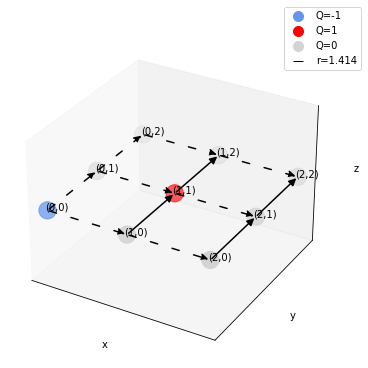

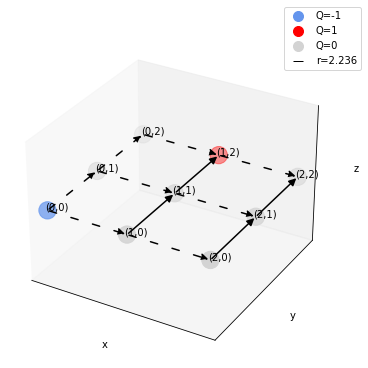

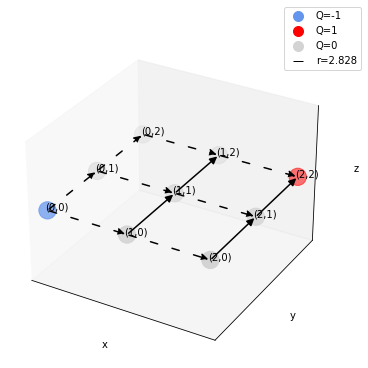

In [5]:
latt.draw_graph_func(gauss_law_fig=True,e_op_free=class_H_oprt1.e_op_free,static_charges=qstat1)
latt.draw_graph_func(gauss_law_fig=True,e_op_free=class_H_oprt1.e_op_free,static_charges=qstat2)
latt.draw_graph_func(gauss_law_fig=True,e_op_free=class_H_oprt1.e_op_free,static_charges=qstat3)

### Circuit

[0, 2, 8, 18]
Total n.er of CNOT gates (Toffoli are decomposed): 24
Total n.er of parameters: 32
CNOT depth: 28


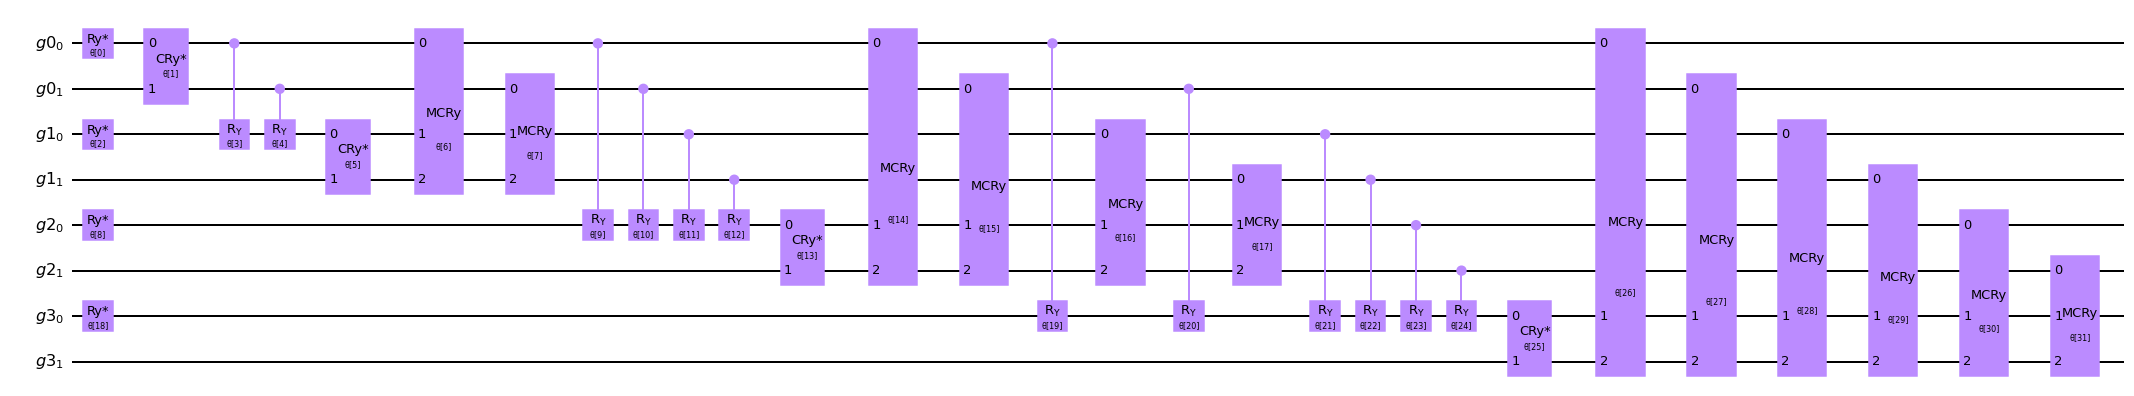

In [34]:
nlayers= 1
entanglement='full'#,linear,full,triangular
rzlayer=False
ngauge = class_H_oprt1.len_e_op
if puregauge:
    n_qubits_f = 0
else:
    n_qubits_f = np.prod(latt.n_sites)

n_qubits =int(np.ceil(np.log2(2 * l+ 1)))

ansatz_class = Ansatz(l,ngauge,nfermions=n_qubits_f)

qc_tot2,first_layer_par,th_gauge= ansatz_class.puregauge_circuit_entang(entanglement=entanglement,rzlayer=rzlayer,nlayers=nlayers)
print(first_layer_par)
print('Total n.er of CNOT gates (Toffoli are decomposed):',dict(qc_tot2.decompose().count_ops())['cx'])
print('Total n.er of parameters:',qc_tot2.num_parameters)
depth = qc_tot2.decompose().depth(lambda x: x[0].num_qubits == 2)
print("CNOT depth:",depth)
#print(ansatz_class.first_layer_par)
#parameter counts
#print(ansatz_class.parameters_count(n_qubits,ngauge))
qc_tot2.draw('mpl',fold=50,style='clifford')


##### New improved ansatz proposal

In [7]:
for i,k in enumerate(class_H_oprt1.uop_list):
    print(f'qubit{i}:{k}')

qubit0:U_21y
qubit1:U_11y
qubit2:U_20y
qubit3:U_10y


Total n.er of CNOT gates (Toffoli are decomposed): 64
Total n.er of parameters: 17
CNOT depth: 63


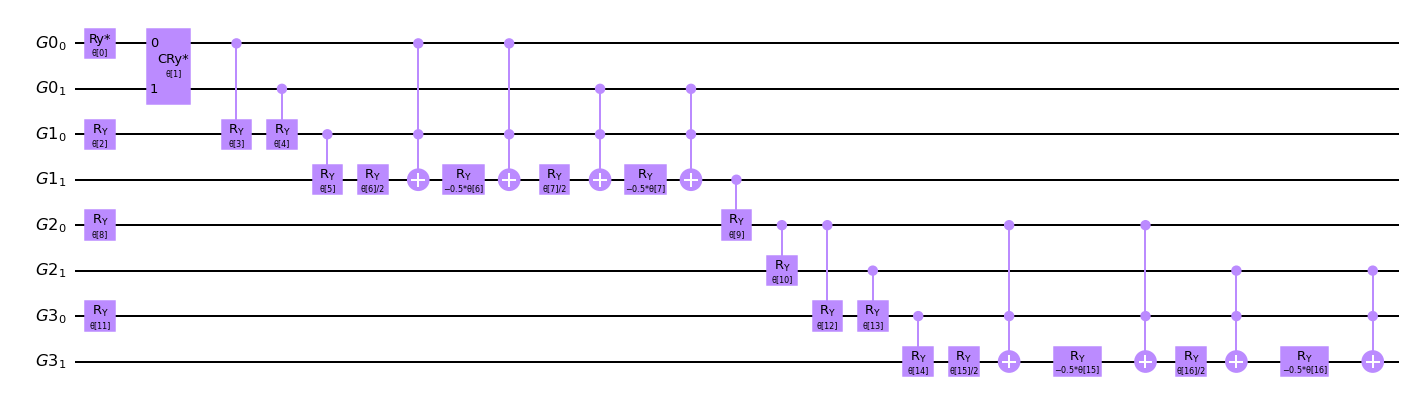

In [48]:
#XXX 3x3 OBC mutual info circuit
from qiskit.circuit import Parameter

#circuit with ngauge quantum registers
qregisters=[]
for i in range(ansatz_class.ngauge):

    qregisters.append(QuantumRegister(ansatz_class.n_qubits,name=f'G{i}'))
qc_tot2 = QuantumCircuit(*qregisters)

th_gauge=0
#U10y
qc_tot2.compose(ansatz_class.gray_code_lim(theta=th_gauge,layers=nlayers)[0],list(range(ansatz_class.n_qubits)),inplace=True)
th_gauge=int(''.join(list(filter(str.isdigit, str(ansatz_class.gray_code_lim(theta=th_gauge,layers=nlayers)[1][-1])))))+1

#U21y
qc_tot2.ry(Parameter(f"θ[{th_gauge}]"),2)
th_gauge+=1
for n in range(ansatz_class.n_qubits-1):
    for j in [0,1]:
        qc_tot2.cry(Parameter(f"θ[{th_gauge}]"),j+n,ansatz_class.n_qubits+n)
        th_gauge+=1
qc_tot2.cry(Parameter(f"θ[{th_gauge}]"),2,3)
th_gauge+=1
for i in [0,1]:
    qc_tot2.mcry(Parameter(f"θ[{th_gauge}]"),[i,2],3)
    th_gauge+=1
#qc_tot2.barrier()

qc_tot2.ry(Parameter(f"θ[{th_gauge}]"),4)
th_gauge+=1

qc_tot2.cry(Parameter(f"θ[{th_gauge}]"),3,4)
th_gauge+=1

qc_tot2.cry(Parameter(f"θ[{th_gauge}]"),4,5)
th_gauge+=1

qc_tot2.ry(Parameter(f"θ[{th_gauge}]"),ansatz_class.ngauge*ansatz_class.n_qubits-2)
th_gauge+=1
for n in range(ansatz_class.n_qubits-1):
    for j in [4,5]:
        qc_tot2.cry(Parameter(f"θ[{th_gauge}]"),j+n,ansatz_class.n_qubits*(ngauge-1)+n)
        th_gauge+=1
qc_tot2.cry(Parameter(f"θ[{th_gauge}]"),6,7)
th_gauge+=1
for i in [4,5]:
    qc_tot2.mcry(Parameter(f"θ[{th_gauge}]"),[i,6],7)
    th_gauge+=1

first_layer_par=[0,2,8,11] #XXX for initial vacuum state

print('Total n.er of CNOT gates (Toffoli are decomposed):',dict(qc_tot2.decompose().count_ops())['cx'])
print('Total n.er of parameters:',qc_tot2.num_parameters)
depth = qc_tot2.decompose().depth(lambda x: x[0].num_qubits == 2)
print("CNOT depth:",depth)
qc_tot2.draw('mpl',fold=50,style='clifford')

#### Plot data

In [9]:
import re
def read_datafile(filetxt):
    filename = filetxt  # Replace this with the actual path to your file

    # Define regular expressions to extract the required data
    pattern_g= r'g(-?\d+\.\d+)'
    pattern_ed = r'E_0\(ED\)= (-?\d+\.\d+)'
    pattern_vqd = r'E_0\(VQD\)= (-?\d+\.\d+)'
    pattern_vqd_data = r'data: \[(-?\d+\.\d+)'
    pattern_std_dev = r'std\. dev\. (-?\d+\.\d+)'
    pattern_fidelity = r'E_0: (\d+\.\d+)'
    pattern_parameters = r'Parameters: \[([\s\d\.\-\+eE]+)\]'

    ed_values = []
    vqd_values = []
    std_dev_values = []
    fidelity_values = []
    parameters_values = []

    with open(filename, 'r') as file:
        data = file.read()

        # Extract g value
        g_vals = np.array(list(set(map(float, re.findall(pattern_g, data)))))

        # Extract E_0(ED) values
        ed_values = np.array(list(map(float, re.findall(pattern_ed, data))))

        # Extract E_0(VQD) values
        vqd_values = np.array(list(map(float, re.findall(pattern_vqd, data))))

        # Extract std. dev. values
        std_dev_values = np.array(list(map(float, re.findall(pattern_std_dev, data))))

        # Extract Fidelity (|psi_VQDXpsi_ED|^2) values
        fidelity_values = np.array(list(map(float, re.findall(pattern_fidelity, data))))

        # Extract Parameters values
        parameters_matches = re.finditer(pattern_parameters, data)
        parameters_list = [np.array(list(map(float, match.group(1).split()))) for match in parameters_matches]

    return ed_values, vqd_values, std_dev_values, fidelity_values, parameters_list,g_vals

In [10]:

#Shot noise and combination on NFT and COBYLA optimizer
ed_values, vqd_values_noise, std_dev_values_noise,fidelity_values_noise,param_values,g_vals=read_datafile(f'step_scaling_match1.4_vqe_results_noisel{l}_purpleNFTCOBYLA.txt')

g_vals=sorted(g_vals)[::-1]

print(ed_values,vqd_values_noise,std_dev_values_noise,fidelity_values_noise)
#Data exact diagonalisation
Fr1_g1=[r1**2*(ed_values[i+1]-ed_values[i])/(r2-r1) for i in range(0,len(ed_values)-1,3)]
Fr2_g1=[r2**2*(ed_values[i+1]-ed_values[i])/(r3-r2) for i in range(1,len(ed_values)-1,3)]
#Data with shotnoise
Fr1_g1_vqd=[r1**2*(vqd_values_noise[i+1]-vqd_values_noise[i])/(r2-r1) for i in range(0,len(vqd_values_noise)-1,3)]
Fr2_g1_vqd=[r2**2*(vqd_values_noise[i+1]-vqd_values_noise[i])/(r3-r2) for i in range(1,len(vqd_values_noise)-1,3)]
if len(std_dev_values_noise)>0:
    #std dev F=np.sqrt(std_dev_values_noise[1]**2+std_dev_values_noise[2]**2)
    stdev_Fr1_vqd=[np.sqrt(std_dev_values_noise[i+1]**2+std_dev_values_noise[i]**2) for i in range(0,len(vqd_values_noise)-1,3)]
    stdev_Fr2_vqd=[np.sqrt(std_dev_values_noise[i+1]**2+std_dev_values_noise[i]**2) for i in range(1,len(vqd_values_noise)-1,3)]
else:
    stdev_Fr1_vqd=[]
    stdev_Fr2_vqd=[]
print(Fr1_g1_vqd,Fr2_g1_vqd,stdev_Fr1_vqd,stdev_Fr2_vqd)

[  -1.47862746   -1.25165883   -1.13060962  -14.50633813  -14.4263829
  -14.36083977  -53.314703    -53.29113324  -53.26802749 -183.85752383
 -183.85066128 -183.84381053] [  -1.43524428   -1.22695111   -1.09882753  -14.49338357  -14.4097235
  -14.34572443  -53.30205026  -53.27989683  -53.25860303 -183.82004825
 -183.81314369 -183.81938055] [0.00047878 0.00030728 0.00036298 0.00036601 0.00039329 0.00042267
 0.00022298 0.00019955 0.00018873 0.00058724 0.00061531 0.00053994] [0.9887968  0.99030794 0.9876968  0.99812107 0.99796613 0.9983272
 0.99952816 0.99947722 0.99969086 0.99945318 0.99945245 0.99973039]
[0.5068858100861243, 0.2035885200551435, 0.05391085228854961, 0.016802389528026214] [1.0814687456384438, 0.5402049989275045, 0.17973723788349585, -0.05264431784689136] [0.000568903202671495, 0.0005372499572528611, 0.0002992353593652582, 0.00085056460656715] [0.0004755749827976409, 0.0005773442577222507, 0.0002746631445824307, 0.0008186217699118931]


The static forces are computed as:$F(r_2,g)=V(r_3,g)-V(r_2,g)/(r_3-r_2)$, $F(r_1,g)=V(r_2,g)-V(r_1,g)/r_2-r_1$

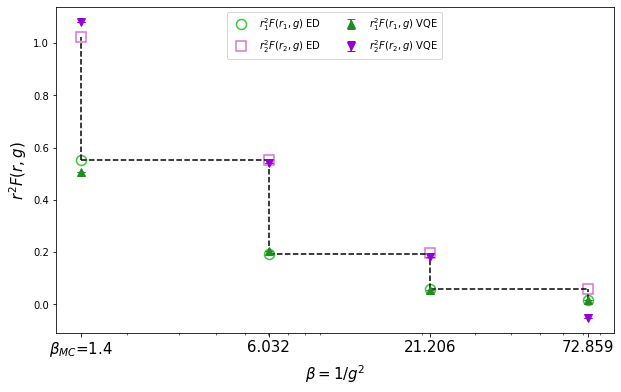

In [11]:
# Plot
fig=plt.figure(figsize=(10,6))
ax = plt.axes()

points=4

ax.plot(1/np.array(g_vals[:points])**2,Fr1_g1[:points],'o',label=f'$r_1^2F(r_1,g)$ ED',markersize=10,color='limegreen',markerfacecolor='none',markeredgewidth=1.5)
ax.plot(1/np.array(g_vals[:points])**2,Fr2_g1[:points],'s',label=f'$r_2^2F(r_2,g)$ ED',markersize=10,color='orchid',markerfacecolor='none',markeredgewidth=1.5)

if len(std_dev_values_noise)>0:
    ax.errorbar(1/np.array(g_vals[:points])**2,Fr1_g1_vqd[:points],yerr=stdev_Fr1_vqd[:points],marker='^',label=f'$r_1^2F(r_1,g)$ VQE',markersize=8,color='forestgreen',linestyle='',capsize=4)
    ax.errorbar(1/np.array(g_vals[:points])**2,Fr2_g1_vqd[:points],yerr=stdev_Fr2_vqd[:points],marker='v',label=f'$r_2^2F(r_2,g)$ VQE',markersize=8,color='darkviolet',linestyle='',capsize=4)
else:
    ax.plot(1/np.array(g_vals[:points])**2,Fr1_g1_vqd[:points],marker='^',label=f'$r_1^2F(r_1,g)$ VQE',markersize=8,color='limegreen',linestyle='')
    ax.plot(1/np.array(g_vals[:points])**2,Fr2_g1_vqd[:points],marker='v',label=f'$r_2^2F(r_2,g)$ VQE',markersize=8,color='forestgreen',linestyle='')

#grid through the points also y direction
for i in range(len(g_vals[:points])-1):#orizontal
    ax.plot([1/np.array(g_vals[:points][i])**2,1/np.array(g_vals[:points][i+1])**2],[Fr1_g1[:points][i],Fr1_g1[:points][i]],'k--')
for i in range(len(g_vals[:points])):#vertical
    ax.plot([1/np.array(g_vals[:points][i])**2,1/np.array(g_vals[:points][i])**2],[Fr1_g1[:points][i],Fr2_g1[:points][i]],'k--')

ax.legend(fontsize=15)
ax.set_xlabel(r'$\beta=1/g^2$',size=15)
ax.set_ylabel('$r^2F(r,g)$',size=15)
# Manually set the tick labels for the x-axis
ax.set_xscale('log')
new_tick_labels = [r"$\beta_{MC}$="+str(np.round(1/g_vals[0]**2,4)), *np.round(1/np.array(g_vals[1:points])**2,3)]  # Using LaTeX for the first tick label
ax.set_xticks(1/np.array(g_vals[:points])**2)
ax.set_xticklabels(new_tick_labels,fontsize=15)

ax.legend(ncol=2,loc=9)
plt.show()

[-1.47862746]


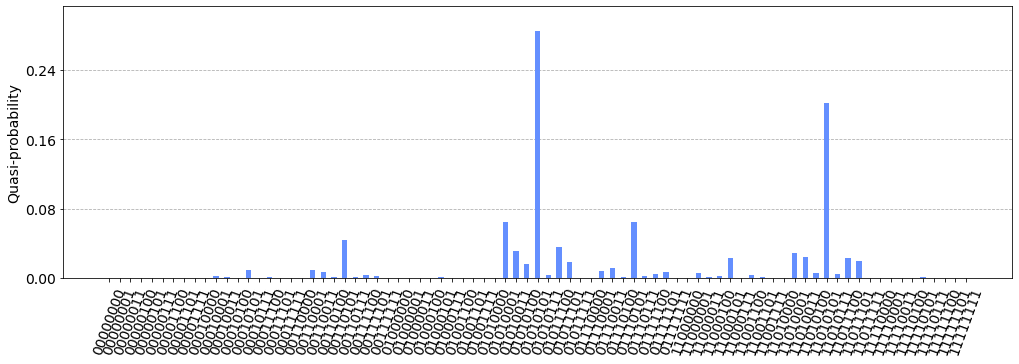

In [12]:
#TODO: change val of g and class_H_oprt{1,2,3} to get the Hamiltonian for the 3 distances (example with class_H_oprt1, i.e. qstat1)
g=g_vals[0];g
Hamiltonian_Pauli_tot_vqd = class_H_oprt1.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_e_op,lambd=0).simplify()
Hamiltonian_Pauli_tot = class_H_oprt1.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_e_op,lambd=lambd)

#ED
import scipy.sparse as sp

if encoding=='gray' and not sparse_pauli:
    Hamiltonian_Pauli_tot = Hamiltonian_Pauli_tot.to_matrix(sparse=True)
elif encoding=='ed':
    Hamiltonian_Pauli_tot = sp.csr_matrix(Hamiltonian_Pauli_tot)

#** Exact diagonalisation
spectrum, eigenvectors_matrix =primme.eigsh(Hamiltonian_Pauli_tot,k=num_eigs,which="SA")#,ncv = 30)
#spectrum
idx = spectrum.argsort()
spectrum = spectrum[idx]
eigenvectors_matrix = eigenvectors_matrix[:,idx]


ed_val = []
for kk in range(num_eigs):
    ed_val.append(dict([(str(np.binary_repr(i, width = (ngauge*n_qubits+n_qubits_f))),np.abs(eigenvectors_matrix[:,kk][i])**2) for i in range(2**(ngauge*n_qubits+n_qubits_f)) if np.abs(eigenvectors_matrix[:,kk][i])**2>1e-10]))

print(spectrum)

plot_distribution(ed_val[0],figsize=(17,5),bar_labels=False)

#### VQE single run

Options() <qiskit_algorithms.optimizers.slsqp.SLSQP object at 0x7fa7291cc250>


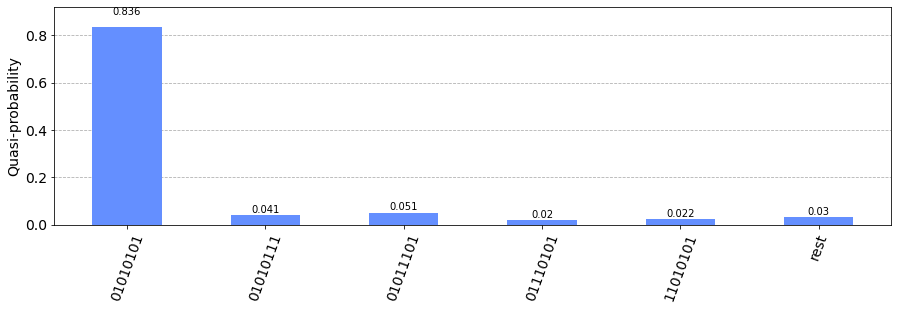

In [13]:
#Input parameters
estimator = Estimator()
sampler = Sampler()

aux_operators =None
nshots=None#10000
iterations = 200 #TODO: only as example
if nshots:
    #optimizer=SPSA(maxiter=iterations)
    optimizer=NFT(maxiter=iterations,maxfev=3*iterations+500)#, disp=True, reset_interval=1) #NFT,SLSQP,COBYLA,ADAM,SPSA,QNSPSA,CG,GradientDescent,L_BFGS_B   #SPSA(maxiter=iterations)#
    estimator.set_options(shots=nshots)
else:
    optimizer = SLSQP(maxiter=iterations)


print(estimator.options,optimizer)
ansatz = qc_tot2
#random initial parameters
#*** initial point
# initial_point=np.pi/4*(2*np.random.rand(ansatz.num_parameters)-1.0)

import re
#initial point focused on the vacuum state
initial_point = np.zeros(qc_tot2.num_parameters)
for k,i in enumerate([int(re.search(r'\d+', str(param)).group()) for param in qc_tot2.parameters]):
    initial_point[k]=np.pi if i in first_layer_par else np.pi/6*(2*np.random.rand(1)-1.0)[0]

plot_distribution(Statevector(qc_tot2.assign_parameters(initial_point)).probabilities_dict(),figsize=(15, 4),number_to_keep=5)



In [14]:
#VQE
#callback function
E_data = [[] for k in range(num_eigs)]
Fidelity = [[] for k in range(num_eigs)]
def callback(eval_count, parameters, mean, meta):
    now = datetime.datetime.now()
    stdout.write("eig: %d/%d -> its %4d \r"%(1,num_eigs,eval_count))
    stdout.flush()
    E_data[0].append([len(E_data[0]),mean,meta])
    #fidelity
    vqd_states = [ansatz.assign_parameters(parameters) for i in range(num_eigs)]
    vqd_fid_states =[qinf.Statevector.from_instruction(i) for i in vqd_states]
    ed_fid_states =[Statevector(eigenvectors_matrix[:,i]) for i in range(num_eigs)]
    Fidelity[0].append([qinf.state_fidelity(vqd,ed) for vqd,ed in zip(vqd_fid_states,ed_fid_states)])

vqe=VQE(estimator, ansatz, optimizer,initial_point=initial_point,  callback=callback)
result = vqe.compute_minimum_eigenvalue(operator = Hamiltonian_Pauli_tot_vqd,aux_operators = aux_operators)# Hamiltonian + auxiliary operator
vqd_values = result.eigenvalue

print(vqd_values)

#eigenvectors
vqd2_eigenstates = []
tmp = result.optimal_circuit.copy()

tmp.measure_all()
opt_pt =list(result.optimal_parameters.values())
res = sampler.run(tmp, opt_pt).result()

vqd2_eigenstates.append({x:round(y,6) for x,y in res.quasi_dists[0].binary_probabilities().items() if y>0.0001})
tmp.remove_final_measurements()


-1.46272200127070128 


Options()
E_i ED vs VQE test:2D_3x3mbasisFalse puregaugeTrue g0.8451542547285166 pbcFalse l1_factE1_factB1_m0_Omega0iterations200 entang.triangular optim. SLSQP
E_0(ED)= -1.47862746
E_0(VQE)= -1.4627220012707012
last point of callback data: [667, -1.462722001272347, {}]
Fidelity (|psi_VQDXpsi_ED|^2):
E_0: 0.9943896678738077
Check if in VQE sol. there are unphysical states: Gauge fields: ['10'] Fermions: only zero charge are considered physical
E_0 all physical states reached gauge fields: OK!
Parameters: [ 2.49997505  0.86938009  3.10890584 -0.2568103  -1.10294641  2.65275207
 -1.27538253 -1.04566224  0.63079319  3.02081626 -0.65877889 -1.64072034
  2.07731226 -1.53348358 -0.35304717  2.73832041 -0.02811304]


Text(0.5, 0, 'iterations')

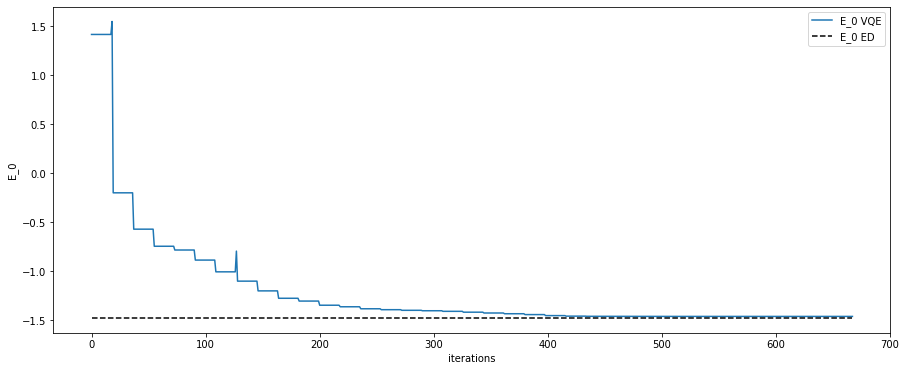

In [15]:
#print results
print(estimator.options)
print(f'E_i ED vs VQE test:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis} puregauge{puregauge} g{g} pbc{pbc} l{l}_factE{fact_e_op}_factB{fact_b_op}_m{m}_Omega{omega}iterations{iterations} entang.'+entanglement+' optim. '+
[i for i in ['NFT','SLSQP','COBYLA','ADAM','SPSA','GradientDescent','CG','L_BFGS_B','P_BFGS','SciPyOptimizer','AQGD','CustomNFT'] if i in str(optimizer)][0])
#print('Q_static:',qstat)
#** Print results
for kk,evalu in enumerate(spectrum[:1]):
        if evalu<900:# only physical states, 1000 corresponds to factor of penalty term
            print(f'E_{kk}(ED)=',round(evalu,8))#,[(str(np.binary_repr(i, width = (ngauge*n_qubits))),round(np.abs(eigenvectors_matrix[:,kk][i])**2,6)) for i in range(2**(ngauge*n_qubits)) if np.abs(eigenvectors_matrix[:,kk][i])**2>1e-4])
            print(f'E_{kk}(VQE)=',vqd_values.real)#,vqd2_eigenstates[kk])

if nshots:
    print('last point of callback data:',E_data[0][-1][1:],'std. dev.',np.sqrt(E_data[0][-1][-1]['variance']/E_data[0][-1][-1]['shots']))

    # print('Check if the variational result-err. is within the exact result:E_0(VQE)-std.dev.(',
    #     (E_data[0][-1][1]-(np.sqrt(E_data[0][-1][-1]['variance']/E_data[0][-1][-1]['shots']))),') <= E_0(ED) (',spectrum[0],')')
else:
    print('last point of callback data:',E_data[0][-1])

# #** Fidelity final (two options, same result)
#fid=fidelity_func(result,eigenvectors_matrix,num_eigs)
fid = Fidelity[0][-1]
print('Fidelity (|psi_VQDXpsi_ED|^2):')
[print(f'E_{i}:',fd) for i,fd in enumerate(fid)]


#**Check if there are unphysical states
gray_unph = []
for i in range(2 * l + 1, 2**int(np.ceil(np.log2(2 * l+ 1)))):
    gray_decimal = i ^ (i >> 1)
    gray_unph.append("{0:0{1}b}".format(gray_decimal,int(np.ceil(np.log2(2 * l+ 1)))))

ferm_q0 = [''.join(i) for i in permutations(['0','1']*(n_qubits//2),n_qubits)]

print('Check if in VQE sol. there are unphysical states: Gauge fields:',gray_unph,'Fermions: only zero charge are considered physical')
for i in range(num_eigs):
    if ngauge:
        for vqd_res in [string[-(ngauge*n_qubits):][i:i+int(np.ceil(np.log2(2 * l+ 1)))] for string in vqd2_eigenstates[i].keys() for i in range(0, len(string[-(ngauge*n_qubits):]), int(np.ceil(np.log2(2 * l+ 1))))]:
            if vqd_res in gray_unph:
                print('unphysical state reached for gauge fields')
                break
        else:
            print(f'E_{i} all physical states reached gauge fields: OK!')
    if n_qubits_f:
        for vqd_res in [string[:n_qubits_f] for string in vqd2_eigenstates[i].keys() ]:

            if vqd_res in ferm_q0:
                print('unphysical state reached for fermions')
                break
        else:
            print(f'E_{i} all physical states reached fermions: OK!')

#parameters
print('Parameters:',result.optimal_point)

fig =plt.figure(figsize=(15,6))
plt.plot([i[0] for i in E_data[0]],[i[1] for i in E_data[0]],label=f'E_{0} VQE')
plt.hlines(spectrum[0],E_data[0][0][0],E_data[0][-1][0],linestyles='dashed',color='black',label=f'E_{0} ED')

plt.legend()
plt.ylabel('E_0')
plt.xlabel('iterations')

#### More runs

In [49]:
#Input parameters
estimator = Estimator()
sampler = Sampler()

aux_operators =None
nshots=None#10000
iterations = 1000
if nshots:
    #optimizer=SPSA(maxiter=iterations)
    optimizer=NFT(maxiter=iterations,maxfev=3*iterations+500)#, disp=True, reset_interval=1) #NFT,SLSQP,COBYLA,ADAM,SPSA,QNSPSA,CG,GradientDescent,L_BFGS_B   #SPSA(maxiter=iterations)#
    estimator.set_options(shots=nshots)
else:
    optimizer = SLSQP(maxiter=iterations)

ansatz = qc_tot2
#random initial parameters
#*** initial point
# initial_point=np.pi/4*(2*np.random.rand(ansatz.num_parameters)-1.0)

import re

#ED
import scipy.sparse as sp

In [63]:
# vqe_res=[]
# fid_res=[]
# ed_res=[]
# optim_points=[]
# for g in g_vals:
#    #TODO: change val of g and class_H_oprt{1,2,3} to get the Hamiltonian for the 3 distances (example with class_H_oprt1, i.e. qstat1)
#     Hamiltonian_Pauli_tot_vqd = class_H_oprt3.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_e_op,lambd=0).simplify()
#     Hamiltonian_Pauli_tot = class_H_oprt3.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_e_op,lambd=lambd)

#     if encoding=='gray' and not sparse_pauli:
#         Hamiltonian_Pauli_tot = Hamiltonian_Pauli_tot.to_matrix(sparse=True)
#     elif encoding=='ed':
#         Hamiltonian_Pauli_tot = sp.csr_matrix(Hamiltonian_Pauli_tot)

#     #** Exact diagonalisation
#     spectrum, eigenvectors_matrix =primme.eigsh(Hamiltonian_Pauli_tot,k=num_eigs,which="SA")#,ncv = 30)
#     #spectrum
#     idx = spectrum.argsort()
#     spectrum = spectrum[idx]
#     eigenvectors_matrix = eigenvectors_matrix[:,idx]

#     #initial point focused on the vacuum state
#     initial_point = np.zeros(qc_tot2.num_parameters)
#     for k,i in enumerate([int(re.search(r'\d+', str(param)).group()) for param in qc_tot2.parameters]):
#         initial_point[k]=np.pi if i in first_layer_par else np.pi/6*(2*np.random.rand(1)-1.0)[0]

#     #VQE
#     #callback function
#     E_data = [[] for k in range(num_eigs)]
#     Fidelity = [[] for k in range(num_eigs)]
#     def callback(eval_count, parameters, mean, meta):
#         now = datetime.datetime.now()
#         stdout.write("eig: %d/%d -> its %4d \r"%(1,num_eigs,eval_count))
#         stdout.flush()
#         E_data[0].append([len(E_data[0]),mean,meta])
#         #fidelity
#         vqd_states = [ansatz.assign_parameters(parameters) for i in range(num_eigs)]
#         vqd_fid_states =[qinf.Statevector.from_instruction(i) for i in vqd_states]
#         ed_fid_states =[Statevector(eigenvectors_matrix[:,i]) for i in range(num_eigs)]
#         Fidelity[0].append([qinf.state_fidelity(vqd,ed) for vqd,ed in zip(vqd_fid_states,ed_fid_states)])

#     vqe=VQE(estimator, ansatz, optimizer,initial_point=initial_point,  callback=callback)
#     result = vqe.compute_minimum_eigenvalue(operator = Hamiltonian_Pauli_tot_vqd,aux_operators = aux_operators)# Hamiltonian + auxiliary operator
#     vqd_values = result.eigenvalue

#     fid = Fidelity[0][-1]
#     print(g,vqd_values,spectrum[0],fid)

#     vqe_res.append(vqd_values)
#     fid_res.append(fid[0])
#     ed_res.append(spectrum[0])
#     optim_points.append(result.optimal_point)



0.8451542547285166 -1.1033739753937586 -1.1306096242687804 [0.9887495055308528]
0.4071542547285162 -14.358153820493417 -14.360839772811275 [0.999509107693604]
0.21715425472851602 -53.26794339308222 -53.268027489449295 [0.9999951442465813]
0.11715425472851593 -183.8438083392249 -183.8438105331416 [0.9999999629811992]


In [69]:
#data for Vr1 and reduced ansatz
vqe_res_reducedvr1=[-1.462722087918644,
 -14.503619880884914,
 -53.31461883419711,
 -183.85752133885546]

fid_res_reducedvr1=[0.9943831655601889,
 0.9995014714638427,
 0.9999951410943789,
 0.9999999597091096]
ed_res_reducedvr1=[-1.478627459661963,
 -14.506338130827212,
 -53.31470300123117,
 -183.85752382517305]
optim_points_reducedvr1=[np.array([ 2.50023448,  0.86908962,  3.10682043, -0.25443243, -1.1052652 ,
         2.65159337, -1.27540035, -1.04342576,  0.63068689,  3.0230751 ,
        -0.66131512, -1.64117287,  2.07756731, -1.53386669, -0.34937051,
         2.73799463, -0.02810389]),
 np.array([ 2.12096437e+00,  1.20507011e+00,  2.73544705e+00, -4.64619913e-01,
        -6.68754036e-01,  1.76469175e+00, -5.96142892e-01, -4.49235549e-01,
         1.09722008e+00,  2.66199822e+00, -5.17463437e-01, -6.70712646e-01,
         1.65006584e+00, -5.92039206e-01, -4.07326438e-01,  2.24840982e+00,
        -1.66597628e-03]),
 np.array([ 2.12456651e+00,  1.18308638e+00,  2.62397262e+00, -4.52649196e-01,
        -5.87792787e-01,  1.64469883e+00, -5.14674578e-01, -3.78614841e-01,
         1.17175981e+00,  2.61573507e+00, -4.56703246e-01, -5.87396520e-01,
         1.63400683e+00, -5.14336813e-01, -3.74895027e-01,  2.13837876e+00,
        -1.21519638e-04]),
 np.array([ 2.12613674e+00,  1.18014425e+00,  2.61276659e+00, -4.50740727e-01,
        -5.80344661e-01,  1.63383776e+00, -5.07656432e-01, -3.72046010e-01,
         1.17924106e+00,  2.61206049e+00, -4.51127750e-01, -5.80253050e-01,
         1.63303320e+00, -5.07688983e-01, -3.71834581e-01,  2.12722065e+00,
         1.75022503e-05])]


#data for Vr2 and reduced ansatz
vqe_res_reducedvr2=[-1.2281846750238548,
 -14.423670558223437,
 -53.29104934891995,
 -183.85065865924523]

fid_res_reducedvr2=[0.9904118097495149,
 0.9995026319129086,
 0.9999951571862181,
 0.9999999573951681]
ed_res_reducedvr2=[-1.2516588250509146,
 -14.426382896884025,
 -53.29113323656654,
 -183.85066128327608]
optim_points_reducedvr2=[np.array([ 2.82065228,  0.87731859,  3.09958934, -0.29823015, -1.24063577,
         2.60763287, -1.41222399, -0.88721347,  0.99103604,  3.11002549,
        -0.2010992 , -0.93454435,  2.70332309, -1.0977    , -1.22835474,
         2.72210991, -0.01346924]),
 np.array([ 2.25676341e+00,  1.17696028e+00,  2.71591821e+00, -4.79775481e-01,
        -6.70965463e-01,  1.73302936e+00, -5.96162410e-01, -4.37767061e-01,
         1.21294688e+00,  2.73899061e+00, -4.61894870e-01, -6.68382939e-01,
         1.77000865e+00, -5.95169679e-01, -4.52334085e-01,  2.21579723e+00,
        -1.85016417e-03]),
 np.array([ 2.13836309e+00,  1.17933799e+00,  2.62102028e+00, -4.53861029e-01,
        -5.87510519e-01,  1.64095044e+00, -5.14419602e-01, -3.77241881e-01,
         1.18321981e+00,  2.62384584e+00, -4.52540299e-01, -5.87494629e-01,
         1.64456898e+00, -5.14447733e-01, -3.78440300e-01,  2.13368426e+00,
        -8.77506028e-05]),
 np.array([ 2.12724502e+00,  1.17980792e+00,  2.61271967e+00, -4.51177529e-01,
        -5.80230121e-01,  1.63354642e+00, -5.07623622e-01, -3.72035872e-01,
         1.18011437e+00,  2.61276624e+00, -4.50731495e-01, -5.80406315e-01,
         1.63380962e+00, -5.07528061e-01, -3.72306502e-01,  2.12683192e+00,
         8.84173935e-06])]


#data for Vr3 and reduced ansatz
vqe_res_reducedvr3=[-1.1033739753937586,
 -14.358153820493417,
 -53.26794339308222,
 -183.8438083392249]

fid_res_reducedvr3=[0.9887495055308528, 0.999509107693604, 0.9999951442465813, 0.9999999629811992]
ed_res_reducedvr3=[-1.1306096242687804,
 -14.360839772811275,
 -53.268027489449295,
 -183.8438105331416]
optim_points_reducedvr3=[np.array([ 2.96930341,  1.0150213 ,  3.10553696, -0.2733645 , -1.14701978,
         2.63772871, -1.33871323, -0.96406671,  1.54853153,  3.11849102,
        -0.17152013, -0.81124349,  2.74011304, -0.97734399, -1.31532339,
         2.79451471, -0.02974779]),
 np.array([ 2.30911563e+00,  1.18070147e+00,  2.71724432e+00, -4.78492211e-01,
        -6.70905994e-01,  1.73476243e+00, -5.95633994e-01, -4.38312631e-01,
         1.26077563e+00,  2.75029608e+00, -4.52485746e-01, -6.70715491e-01,
         1.78709493e+00, -5.93537561e-01, -4.58247048e-01,  2.21978809e+00,
        -1.76362807e-03]),
 np.array([ 2.14318490e+00,  1.17936550e+00,  2.62121147e+00, -4.53979196e-01,
        -5.87351573e-01,  1.64105217e+00, -5.14379441e-01, -3.77340435e-01,
         1.18728948e+00,  2.62488108e+00, -4.51626181e-01, -5.87805646e-01,
         1.64585849e+00, -5.14160468e-01, -3.78786478e-01,  2.13375845e+00,
        -3.76618960e-05]),
 np.array([ 2.12772769e+00,  1.17987561e+00,  2.61258739e+00, -4.50936350e-01,
        -5.80249397e-01,  1.63361483e+00, -5.07611299e-01, -3.72026876e-01,
         1.18054011e+00,  2.61290568e+00, -4.50762345e-01, -5.80202535e-01,
         1.63401295e+00, -5.07563356e-01, -3.72255815e-01,  2.12690177e+00,
         7.95983370e-06])]

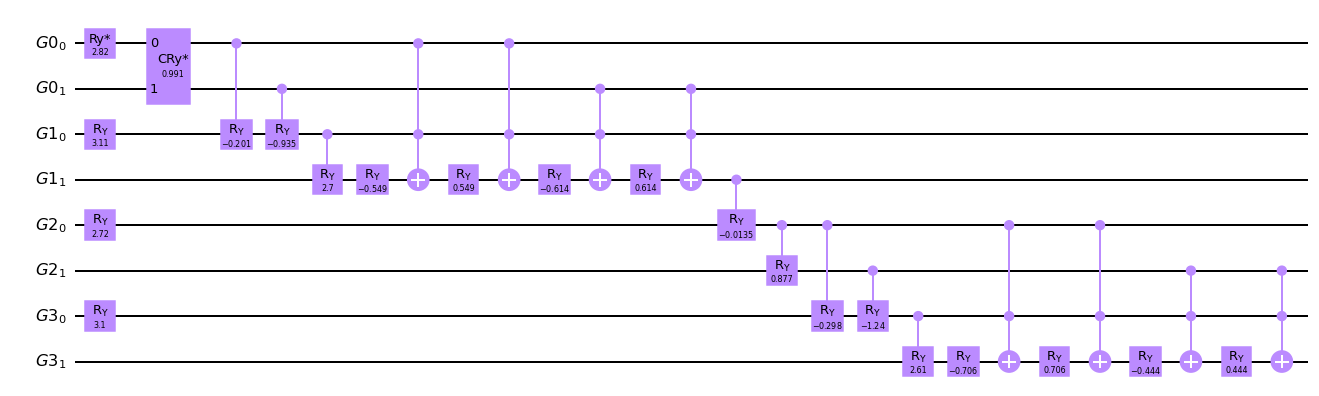

In [76]:
qc_tot2.assign_parameters(optim_points_reducedvr2[0]).draw('mpl',fold=30,style='clifford')